### Determine if an individual makes >$50k based on Census data
Use the Census income dataset from UC Irvine Machine Learning Repository to determine if an individual makes more than $50k from a set of continous and categorical features

In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

### Explore data

In [14]:
df = pd.read_csv('../Data/income.csv')

df = shuffle(df, random_state=37)
df.reset_index(drop=True, inplace=True)

df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,60,Female,Some-college,10,Widowed,Private,Exec-managerial,40,<=50K,0
1,25,Male,Masters,14,Never-married,Private,Prof-specialty,35,<=50K,0
2,32,Male,Bachelors,13,Married,Private,Handlers-cleaners,40,<=50K,0
3,38,Male,Bachelors,13,Married,Private,Exec-managerial,55,>50K,1
4,33,Male,Bachelors,13,Never-married,Private,Handlers-cleaners,30,<=50K,0


In [15]:
# How many vals in each target class?
df['label'].value_counts()
# Looks evenly distributed enough

0    21700
1     8300
Name: label, dtype: int64

In [16]:
# Explore relationship between education and education-num cols
ed = df['education']
ed_num = df['education-num']
unique_combos = list(set(zip(ed,ed_num)))
unique_combos.sort(key=lambda x:x[1])
unique_combos
# It looks like we have a 1:1 mapping between the two, so we can ignore one of them

[('5th-6th', 3),
 ('7th-8th', 4),
 ('9th', 5),
 ('10th', 6),
 ('11th', 7),
 ('12th', 8),
 ('HS-grad', 9),
 ('Some-college', 10),
 ('Assoc-voc', 11),
 ('Assoc-acdm', 12),
 ('Bachelors', 13),
 ('Masters', 14),
 ('Prof-school', 15),
 ('Doctorate', 16)]

In [17]:
# How many occupations are in the data?
df['occupation'].unique()
# Not too many where we'd need to feature engineer or consider consolidating

array(['Exec-managerial', 'Prof-specialty', 'Handlers-cleaners',
       'Machine-op-inspct', 'Other-service', 'Tech-support',
       'Adm-clerical', 'Transport-moving', 'Craft-repair', 'Sales',
       'Farming-fishing', 'Protective-serv'], dtype=object)

In [18]:
# How many ages?
df['age'].nunique()
# Lots of ages, so we will treat this as continuous

72

In [19]:
# No real need to do feature engineering, so we can move on to separating categorical and continuous feats

### Split categorical and continuous cols

In [20]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,60,Female,Some-college,10,Widowed,Private,Exec-managerial,40,<=50K,0
1,25,Male,Masters,14,Never-married,Private,Prof-specialty,35,<=50K,0
2,32,Male,Bachelors,13,Married,Private,Handlers-cleaners,40,<=50K,0
3,38,Male,Bachelors,13,Married,Private,Exec-managerial,55,>50K,1
4,33,Male,Bachelors,13,Never-married,Private,Handlers-cleaners,30,<=50K,0


In [45]:
target = 'label'
cat_cols = ['sex', 'education-num', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']

# Change categorical cols to category dtype
for col in cat_cols:
    df[col] = df[col].astype('category')

# Turn categorical cols ino numpy arrays. Assign #s to each category
cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)

# Convert to PyTorch tensor
cats = torch.tensor(cats, dtype=torch.int64)

# Do the same with the continuous cols
conts = np.stack([df[col].values for col in cont_cols], axis=1)
conts = torch.tensor(conts, dtype=torch.float)

# For classification, we do NOT want to reshape target (y) to be columnar!
target = torch.tensor(df[target], dtype=torch.int64)

### Create embeddings for categorical cols

In [22]:
# Determine # of categories in each categorical feature
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

# Embeddings per category = min(50, sz/2) for each categorical col
emb_szs  = [(size, min(50, (size+1)//2)) for size in cat_szs]
print(f'[(# of categories, # embeddings), ...] = {emb_szs}')

[(# of categories, # embeddings), ...] = [(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]


In [23]:
# Pass cat cols and # of embeddings per to the embedding module
embeds = [nn.Embedding(n_cats, n_embs) for n_cats,n_embs in emb_szs]
print(f'Embeddings = {embeds}')

Embeddings = [Embedding(2, 1), Embedding(14, 7), Embedding(6, 3), Embedding(5, 3), Embedding(12, 6)]


In [24]:
# Create a ModuleList from embeddings
embeds_mod_list = nn.ModuleList(embeds)
print(f'Embeddings ModuleList:\n{embeds_mod_list}')

# The embeddings apply weights to categories. These weights are updated during .backward, allowing the model to learn. See the ny_taxis nb for an example of how the embeddings look for a subset of categorical col categories.

Embeddings ModuleList:
ModuleList(
  (0): Embedding(2, 1)
  (1): Embedding(14, 7)
  (2): Embedding(6, 3)
  (3): Embedding(5, 3)
  (4): Embedding(12, 6)
)


### Define Tabular model

In [36]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        """Initialize the tabular model

        :param emb_szs: List of tuples mapping # of categories and # of embeddings per categorical col
        :type emb_szs: list
        :param n_cont: # of continuous cols
        :type n_cont: int
        :param out_sz: Output size
        :type out_sz: int
        :param layers: Layer size(s)
        :type layers: list
        :param p: Probability of dropout layer, defaults to 0.5
        :type p: float, optional
        """
        
        # Inherit from nn.Module class
        super().__init__()

        # Create embeddings for categorical cols
        self.embeds = nn.ModuleList([nn.Embedding(n_cats, n_embs) for n_cats,n_embs in emb_szs])
        # Create dropout layer - probability embedding(s) will be dropped
        self.emb_drop = nn.Dropout(p)
        # Normalize continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)

        # Establish sequence of NN layers. Each layer will include a linear fn, an activation fn (ReLU), a normalization step and a dropout layer
        layerlist = []
        n_embs = sum([n_embs for n_cats,n_embs in emb_szs])
        n_in = n_embs + n_cont

        # Iteratively build network based on layers param
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i

        # Define output linear layer
        layerlist.append(nn.Linear(layers[-1], out_sz))

        # Combine list of layers
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        """Define how the model will move forward

        :param x_cat: Categorical features
        :type x_cat: torch.tensor
        :param x_cont: Continuous features
        :type x_cont: torch.tensor
        """
        embeddings = []

        # Track embeddings separately for each categorical column, and each value within the column
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))

        # Combine all embeddings into a single tensor per row, tracking all categorical col embeddings
        x = torch.cat(embeddings,1)

        # Add continuous feats to the mix
        x_cont = self.bn_cont(x_cont)  # Normalize cont feats
        x = torch.cat([x,x_cont], 1)
        x = self.layers(x)
        return x

### Create and train model

In [37]:
model = TabularModel(emb_szs=emb_szs, n_cont=conts.shape[1], out_sz=2, layers=[200,100])
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [38]:
# Set criterion (error) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # replacement optimization algo for stochastic gradient descent (SGD)

In [49]:
# Define batch sizes
batch_size = 10000
test_size = int(0.2*batch_size)

# Train/test splits
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:]

y_train = target[:batch_size-test_size]
y_test = target[batch_size-test_size:]

In [55]:
# Train model!
import time
start = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, cont_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    if i%25 == 1:
        print(f'Epoch: {i} \t Loss: {loss}')
    
    optimizer.zero_grad()  # Find where gradient is zero
    loss.backward()  # Step backward thru network
    optimizer.step()  # Update hyperparams

elapsed = time.time() - start
print(f'All done! Training took {round(elapsed/60)} minutes.')

Epoch: 1 	 Loss: 0.8323158621788025
Epoch: 26 	 Loss: 0.4911045432090759
Epoch: 51 	 Loss: 0.4272856116294861
Epoch: 76 	 Loss: 0.3798638582229614
Epoch: 101 	 Loss: 0.35348084568977356
Epoch: 126 	 Loss: 0.3251810371875763
Epoch: 151 	 Loss: 0.30281612277030945
Epoch: 176 	 Loss: 0.2910132110118866
Epoch: 201 	 Loss: 0.28004154562950134
Epoch: 226 	 Loss: 0.2688681483268738
Epoch: 251 	 Loss: 0.2591405510902405
Epoch: 276 	 Loss: 0.25838568806648254
All done! Training took 0 minutes.


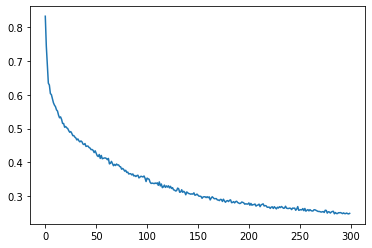

In [57]:
import matplotlib.pyplot as plt

# Plot loss function
plt.plot(range(epochs), [el.item() for el in losses])
# It looks like the loss is starting to level out around 300 epochs. We could probably squeeze a bit more performance out of the model, but this will do

### Validate model on test data

In [63]:
with torch.no_grad():
    y_val = model(cat_test, cont_test)
    loss = criterion(y_val, y_test)
print(f'Loss: {round(loss.item(), 4)}')
# Not entirely sure how to interpret a Cross Entropy Loss of 0.2918

Loss: 0.2918


In [74]:
# Calculate overall % accuracy
correct = 0
for pred,actual in zip(y_val, y_test):
    pred_class = pred.argmax().item()
    actual_class = actual.item()
    if pred_class == actual_class:
        correct += 1
perc_correct = round((correct/len(y_test))*100, 2)
print(f'The model predicted the correct income classification (north/south of $50k) {perc_correct}% of the time.')

The model predicted the correct income classification (north/south of $50k) 86.89% of the time.


In [64]:
# Save the model
torch.save(model.state_dict(), 'income_clf.pt')

### Use the model for inference

In [87]:
# We can (luckily) take advantage of the fact that we already have the TabularModel class defined. If not, we would have to save/load the model to/from a pkl file
emb_szs_pred = [(2,1), (14,7), (6,3), (5,3), (12,6)]
pred_model = TabularModel(emb_szs=emb_szs_pred, n_cont=2, out_sz=2, layers=[200,100])
pred_model.load_state_dict(torch.load('income_clf.pt'))
pred_model.eval()  # Important "step 2" of instantiating the model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [82]:
# Columns refresher
df.head(1)

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,60,Female,Some-college,10,Widowed,Private,Exec-managerial,40,<=50K,0


In [100]:
# Build context dicts to map categorical vals to ints
def cd_builder(df, col):
    """Build a context dict that maps categorical values to integers
    """
    unique_cats = [str(el) for el in df[col].unique()]
    cd = {}
    for i,cat in enumerate(unique_cats):
        cd[cat] = i
    return cd

cat_cols = ['sex', 'education-num', 'marital-status', 'workclass', 'occupation']
ordered_cds = [cd_builder(df, col) for col in cat_cols]

In [168]:
# Gather categorical and continuous features of new person
new_person_cats = [
    'Male',  # sex
    '13',  # education-num
    'Never-married',  # marital-status
    'Private',  # workclass
    'Other-service',  # occupation
]
new_person_conts = [
    24,  # age
    40  # hours-per-week
]

# Map categorical vals to ints using ordered_cds (ordered context dicts - sex, education-num, ..., hours-per-week)
np_cats_ints = [cd[val] for cd,val in zip(ordered_cds, new_person_cats)]

# Create tensor for categorical feats
np_cats_tens = torch.tensor(np_cats_ints, dtype=torch.int64).reshape(1,-1)

# Create tensor for continuous feats
np_conts_tens = torch.tensor(new_person_conts, dtype=torch.float).reshape(1,-1)

print(f'Categories tensor \t{np_cats_tens}\nContinuous tensor \t{np_conts_tens}')

Categories tensor 	tensor([[1, 2, 1, 0, 4]])
Continuous tensor 	tensor([[24., 40.]])


In [166]:
# Take a look at np_embeds (new person categorical columns with embeddings applied!)
# We will pass this through the model, along with the 2 continuous features, in order to get a prediction
# np_embeds_combined

In [154]:
# Use model for inference!

with torch.no_grad():
    new_person_pred = pred_model(np_cats_tens, np_conts_tens).argmax().item()
print(f'New person predicted class: {new_person_pred}')

New person predicted class: 0


The model thinks I make less than 50k ):

Anyways, I had to go through a few steps, and a good bit of trial/error in order to get the model operational for inference.

1) Define the embedding sizes (emb_szs)
2) Call on the TabularModel class to instantiate the model. Use whichever args you want. We are able to call upon the class because it's defined already in the notebook. We have to call upon the TabularModel class bc we are only loading the model as a state dict
3) "Instantiate part 2" with {model}.eval()
4) Build context dictionaries for each of the categorical cols. This is done in order to map the categorical values to integers so that it can be passed to the model as a tensor
5) Create a new person whose income class you'd like to predict (> or < $50k)
6) Separate categorical and continuous features
7) Use the context dicts to map categorical values to integers
8) Map both categorical and continuous features to PyTorch tensors. Ensure each tensor is a single row (.reshape(1,-1))
9) Pass the categories and continuous vals tensors through the model to get a new prediction!

PITFALLS:
I ran into trouble around steps 8 and 9. I thought I had to create the embeddings for the categorical vals. The model takes care of this, however. I pass the model all the information it needs in order to do so (categories tensor and embeddings sizes). In summary, the model should only need 2 things: an array of categorical column values and an array of continuous column values. The array will look something like the following:

[
    [cat embeddings for person 1],
    [cat embeddings for person 2],
    ...
    [cat embeddings for person n]
]

and

[
    [cont_val_1i, cont_val_2i, ..., cont_val_ni],
    ...
    [cont_val_1j, cont_val_2j, ..., cont_val_nj]
]